### Predicting $SPY Price with a LSTM Neural Network

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

%matplotlib inline

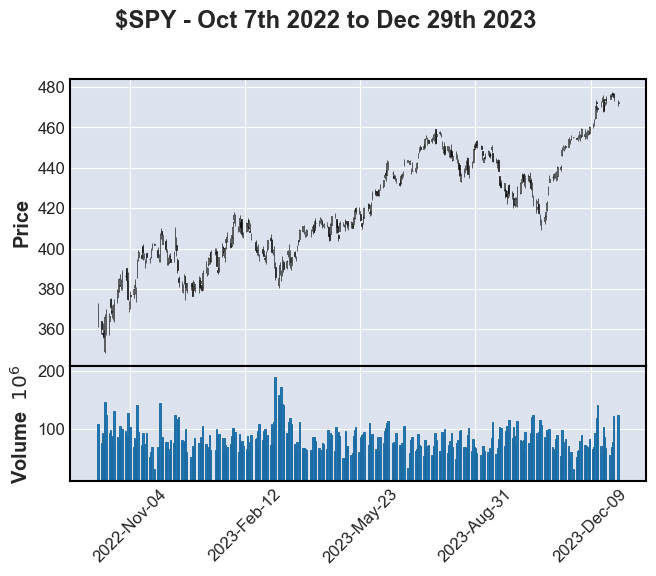

In [20]:
'''
Plot the Date, Open, High, Low, Close, and Volume

Train with: October 7th 2022 - December 29th 2023
Test on: January 1st 2024 - March 1st 2024
'''

df = pd.read_csv('SPY.csv', index_col=0, parse_dates=['Date'], usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

df_train = df.loc['2022-10-07':'2024-01-02']
df_test = df.loc['2023-10-06':'2024-03-01']

mpf.plot(df_train, type='candle', volume=True, show_nontrading=True, title='$SPY - Oct 7th 2022 to Dec 29th 2023')

In [22]:
'''
Prepare the data for training

Only need close prices and volumes, then
regularize them

The input data will be 60 consecutive days worth
of prices and volumes, and the output will be the
61st day's price
'''

train = np.delete(df_train.values, [0, 1, 2], axis=1).astype(np.float32)
test = np.delete(df_test.values, [0, 1, 2], axis=1).astype(np.float32)

scaler = MinMaxScaler(feature_range=(-1, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

train_in = []
train_out = []
for i in range(len(train) - 60):
    train_in.append(train[i:i + 60])
    train_out.append(train[i + 60][0])

test_in = []
test_out = []
for i in range(len(test) - 60):
    test_in.append(test[i:i + 60])
    test_out.append(test[i + 60][0])

train_in = np.array(train_in)
train_out = np.array(train_out)

test_in = np.array(test_in)
test_out = np.array(test_out)

train_in = torch.from_numpy(train_in)
train_out = torch.from_numpy(train_out)

test_in = torch.from_numpy(test_in)
test_out = torch.from_numpy(test_out)

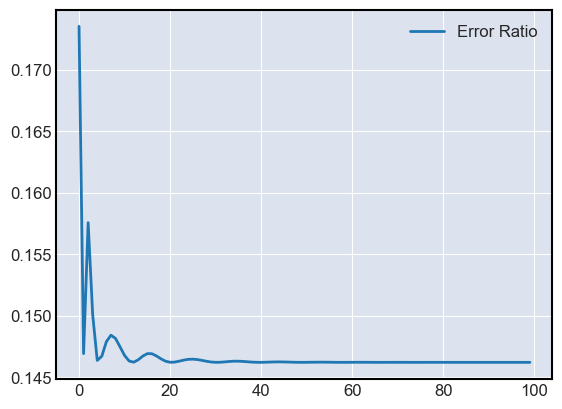

In [17]:
'''
Setup the hyperparameters of the LSTM Neural Network,
then train it

Here, I train over the dataset 100 times
'''

input_dim = 2
hidden_dim = 32
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=True)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, requires_grad=True)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])

        return out

model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    train_pred = model(train_in)

    loss = loss_fn(train_pred, train_out)

    hist[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(hist, label="Error Ratio")
plt.legend()
plt.show()